In [1]:
import numpy as np
import numpy.ma as ma
import scipy.stats as stats
from netCDF4 import Dataset
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cmocean
%matplotlib inline

WORK_DIR = '/Users/dcomeau/Projects/KAF/analysis_scripts_revision/output/predictions/'
SAVE_DIR = '/Users/dcomeau/Projects/KAF/analysis_scripts_revision/figures/'
SEA_ICE_FILE = '/Users/dcomeau/Data/ice/CCSM4/piControl/' + \
    'b40.1850.track1.1deg.006.cice.h.aice_nh.000101-130012.nc'
SIC_DIR = '/Users/dcomeau/Projects/KAF/analysis_scripts_revision/output/'    
SAVE_DIR = '/Users/dcomeau/Projects/KAF/CD_STAPIS/Revision/'
flag = 0
dampedP = 1

Reading data


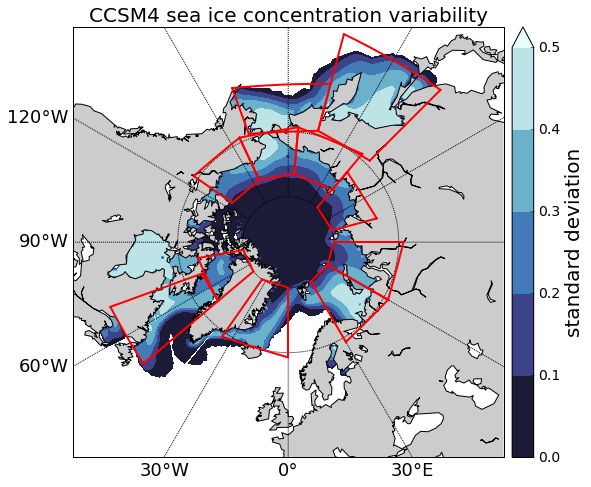

In [2]:
""" Figure 1 """
# load data
print 'Reading data'
fIn = Dataset(SEA_ICE_FILE, mode='r')
gArea = fIn.variables['tarea'][:]  # cm^2: nlat, nlon
gLats = fIn.variables['TLAT'][:]   # degrees north: nlat, nlon
gLons = fIn.variables['TLON'][:]   # degrees east: nlat, nlon
oVar = fIn.variables['aice'][:]    # time(120), z_t (60), nlat(384), nlon(320)
oVar *= 0.01                       # convert % to fraction
[tNum, latNum, lonNum] = np.shape(oVar)
fIn.close()

# get mask
maskInd = ma.nonzero(oVar[0, :, :])
(tmp, nD) = np.shape(maskInd)
maskInd = np.transpose(maskInd)

# map to single unmasked array
dataRaw = np.zeros((tNum, nD))
for i in range(nD):
    dataRaw[:, i] = oVar[:, maskInd[i][0], maskInd[i][1]]

# flip so that columns are time
dataRaw = np.transpose(dataRaw)

dataSD = np.zeros(np.shape(gLats))
for i in range(nD):
    dataSD[maskInd[i][0], maskInd[i][1]] = np.std(dataRaw[i, :])

# draw region boundaries
bLons = np.zeros((11, 2))
bLats = np.zeros((11, 2))

# Beaufort
bLons[0] = [-125, -155]
bLats[0] = [65, 75]
# Chukchi
bLons[1] = [-155, 175]
bLats[1] = [65, 75]
# East Siberian
bLons[2] = [175, 140]
bLats[2] = [65, 75]
# Laptev
bLons[3] = [140, 105]
bLats[3] = [70, 80]
# Kara
bLons[4] = [60, 90]
bLats[4] = [65, 80]
# Barents
bLons[5] = [30, 60]
bLats[5] = [65, 80]
# Greenland
bLons[6] = [0, -35]
bLats[6] = [65, 80]
# Baffin
bLons[7] = [-80, -50]
bLats[7] = [70, 80]
# Labrador
bLons[8] = [-70, -50]
bLats[8] = [50, 70]
# Bering
bLons[9] = [165, -160]
bLats[9] = [55, 65]
# Okhotsk
bLons[10] = [135, 165]
bLats[10] = [45, 65]

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='npstere', lon_0=0.0, boundinglat=45.)
m.drawcoastlines()
m.fillcontinents(color='0.8')
# m.fillcontinents(color = 'coral')
m.drawmeridians(np.arange(0, 360, 30), labels=[1, 0, 0, 1], fontsize=18)
m.drawparallels((66, 80))
for i in range(11):
    m.drawgreatcircle(bLons[i][0], bLats[i][0], bLons[i][1], bLats[i][0],
                      linewidth=2, color='r')
    m.drawgreatcircle(bLons[i][0], bLats[i][0], bLons[i][0], bLats[i][1],
                      linewidth=2, color='r')
    m.drawgreatcircle(bLons[i][1], bLats[i][1], bLons[i][1], bLats[i][0],
                      linewidth=2, color='r')
    m.drawgreatcircle(bLons[i][1], bLats[i][1], bLons[i][0], bLats[i][1],
                      linewidth=2, color='r')

data = dataSD - 1e-10
cLevs = np.linspace(0, 0.5, 6)
cTicks = np.linspace(0, 0.5, 6)
lx, ly = m(gLons, gLats)
cs = m.contourf(lx, ly, data, cLevs, cmap=cmocean.cm.ice, extend='max')
cbar = m.colorbar(cs, location='right')
cbar.set_label('standard deviation', fontsize='20')
cbar.set_ticks(cTicks)
plt.title('CCSM4 sea ice concentration variability', fontsize=20)
plt.savefig('Fig1.eps', format='eps', dpi=1000)

/Users/dcomeau/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


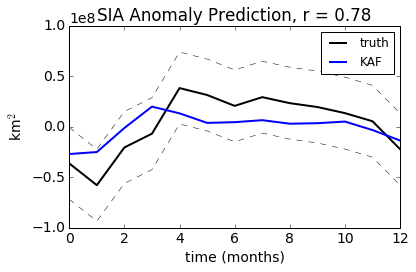

In [3]:
""" Figure 2 """
embedWin = 12
region = 'Arctic'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
truth = dataPredICA['truth']
pred_traj = dataPredICA['pred_traj']
tLagL = dataPredICA['tLag']
tLag = tLagL[0][0]

truthSTD = np.std(truth)

tt = np.linspace(0, tLag - 1, tLag)
thresh = np.ones(tLag) * 0.5

ts = 150
# ts = 160

x = truth[ts, :]
y = pred_traj[ts, :]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': True})
# plt.rcParams.update({'font.family': 'serif'})
plt.figure()
plt.plot(tt, x, 'k', linewidth=2, label='truth')
plt.plot(tt, x + truthSTD, 'k--', linewidth=0.5)
plt.plot(tt, x - truthSTD, 'k--', linewidth=0.5)
plt.plot(tt, y, linewidth=2, label='KAF')
plt.xlim(0, tLag - 1)
plt.xlabel('time (months)')
plt.yticks((-10e7, -5e7, 0, 5e7, 10e7))
plt.ylim(-10e7, 10e7)
plt.ylabel(r'km$^2$')
# plt.title('Sea Ice Area Anomaly Prediction')
plt.title('SIA Anomaly Prediction, r = %.2f' % (r_value))
plt.legend(loc='upper right', prop={'size': 12})
plt.savefig(SAVE_DIR + 'Fig2.eps', format='eps', dpi=1200)

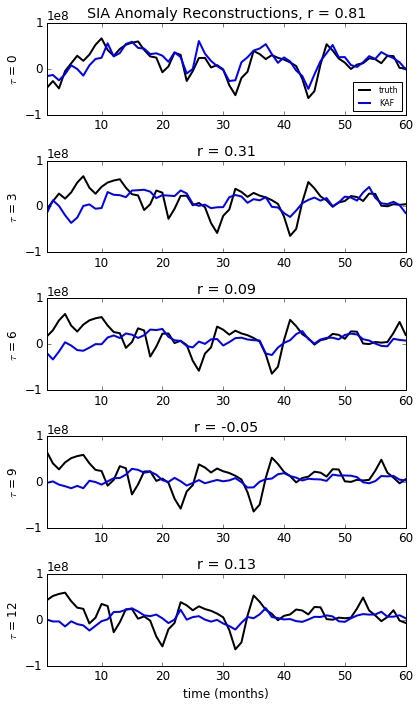

In [4]:
""" Figure 3 """
embedWin = 12
region = 'Arctic'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
data_testF = dataPredICA['data_test']  # 4785
pred_trajF = dataPredICA['pred_traj']  # 4773 x 13

ts = 120
# ts = 150

data_test = data_testF[ts:]
pred_traj = pred_trajF[ts:, :]

pLength = 60
tP = np.linspace(1, pLength, pLength)

lag = [0, 3, 6, 9, 12]

plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

x = np.squeeze(data_test[lag[0]:pLength + lag[0]])
y = pred_traj[:pLength, lag[0]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig = plt.figure()
plt.subplot(5, 1, 1)
plt.plot(tP, x, 'k', label='truth')
plt.plot(tP, y, 'b', label='KAF')
plt.legend(loc='lower right', prop={'size': 8})
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'$\tau$ = ' + str(lag[0]))
plt.title('SIA Anomaly Reconstructions, r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[1]:pLength + lag[1]])
y = pred_traj[:pLength, lag[1]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 2)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'$\tau$ = ' + str(lag[1]))
plt.title('r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[2]:pLength + lag[2]])
y = pred_traj[:pLength, lag[2]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 3)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'$\tau$ = ' + str(lag[2]))
plt.title('r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[3]:pLength + lag[3]])
y = pred_traj[:pLength, lag[3]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 4)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'$\tau$ = ' + str(lag[3]))
plt.title('r = %.2f' % (r_value))

x = np.squeeze(data_test[lag[4]:pLength + lag[4]])
y = pred_traj[:pLength, lag[4]]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(5, 1, 5)
plt.plot(tP, x, 'k')
plt.plot(tP, y, 'b')
plt.xticks([10, 20, 30, 40, 50, 60])
plt.xlim(1, 60)
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'$\tau$ = ' + str(lag[4]))
plt.xlabel('time (months)')
plt.title('r = %.2f' % (r_value))
# plt.tight_layout()
fig.set_figheight(10)
plt.savefig(SAVE_DIR + 'Fig3.eps', format='eps', dpi=1000)

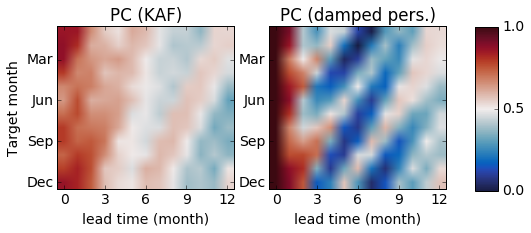

In [5]:
""" Figure 4 """
embedWin = 12
region = 'Arctic'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')

pred_pcTM = dataPredICA['pred_pcTM']
if dampedP == 1:
    pred_pcTMP = dataPredICA['pred_pcTMDP']
else:
    pred_pcTMP = dataPredICA['pred_pcTMP']
cTicks = np.linspace(0, 1, 3)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': False})
# plt.rcParams.update({'font.family': 'serif'})

fig = plt.figure()
plt.subplot(121)
plt.imshow(pred_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('PC (KAF)')
plt.subplot(122)
plt.imshow(pred_pcTMP, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('PC (damped pers.)')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# cax = plt.axes([0.85, 0.1, 0.075, 0.5])
cax = plt.axes([0.85, 0.21, 0.04, 0.57])

plt.colorbar(cax=cax, ticks=cTicks)
fig.set_figwidth(8)
plt.savefig(SAVE_DIR + 'Fig4.eps', format='eps', dpi=1200)

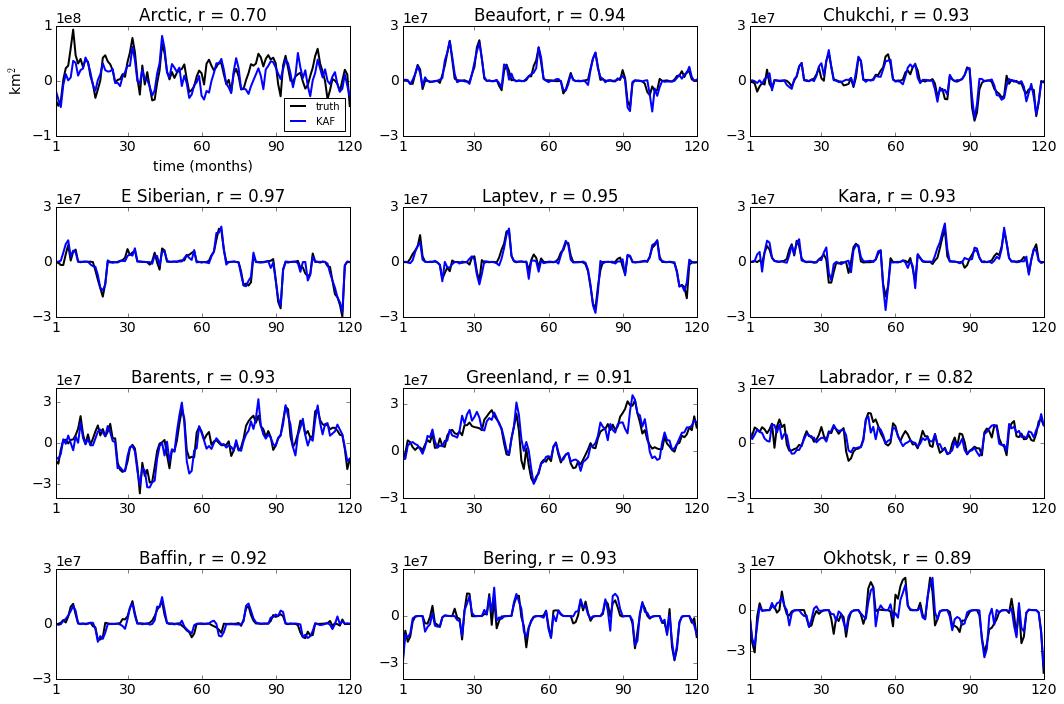

In [6]:
""" Figure 5 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

pred_panel_1_truth = compData['pred_panel_1_truth']
pred_panel_2_truth = compData['pred_panel_2_truth']
pred_panel_3_truth = compData['pred_panel_3_truth']
pred_panel_4_truth = compData['pred_panel_4_truth']
pred_panel_5_truth = compData['pred_panel_5_truth']
pred_panel_6_truth = compData['pred_panel_6_truth']
pred_panel_7_truth = compData['pred_panel_7_truth']
pred_panel_8_truth = compData['pred_panel_8_truth']
pred_panel_9_truth = compData['pred_panel_9_truth']
pred_panel_10_truth = compData['pred_panel_10_truth']
pred_panel_11_truth = compData['pred_panel_11_truth']
pred_panel_12_truth = compData['pred_panel_12_truth']
pred_panel_13_truth = compData['pred_panel_13_truth']
pred_panel_14_truth = compData['pred_panel_14_truth']
pred_panel_15_truth = compData['pred_panel_15_truth']
pred_panel_16_truth = compData['pred_panel_16_truth']

pred_panel_1_ose = compData['pred_panel_1_ose']
pred_panel_2_ose = compData['pred_panel_2_ose']
pred_panel_3_ose = compData['pred_panel_3_ose']
pred_panel_4_ose = compData['pred_panel_4_ose']
pred_panel_5_ose = compData['pred_panel_5_ose']
pred_panel_6_ose = compData['pred_panel_6_ose']
pred_panel_7_ose = compData['pred_panel_7_ose']
pred_panel_8_ose = compData['pred_panel_8_ose']
pred_panel_9_ose = compData['pred_panel_9_ose']
pred_panel_10_ose = compData['pred_panel_10_ose']
pred_panel_11_ose = compData['pred_panel_11_ose']
pred_panel_12_ose = compData['pred_panel_12_ose']
pred_panel_13_ose = compData['pred_panel_13_ose']
pred_panel_14_ose = compData['pred_panel_14_ose']
pred_panel_15_ose = compData['pred_panel_15_ose']
pred_panel_16_ose = compData['pred_panel_16_ose']

tR = 120
tt = np.linspace(1, tR, tR)

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()

x = np.squeeze(pred_panel_1_truth[:tR])
y = np.squeeze(pred_panel_1_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 1)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Arctic, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.xlabel('time (months)')
plt.yticks([-1e8, 0, 1e8])
plt.ylabel(r'km$^2$')
plt.legend(loc='lower right', prop={'size': 10})
plt.legend(loc='lower right', prop={'size': 10})

x = np.squeeze(pred_panel_4_truth[:tR])
y = np.squeeze(pred_panel_4_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 2)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Beaufort, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_3_truth[:tR])
y = np.squeeze(pred_panel_3_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 3)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Chukchi, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_6_truth[:tR])
y = np.squeeze(pred_panel_6_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 4)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('E Siberian, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_7_truth[:tR])
y = np.squeeze(pred_panel_7_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 5)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Laptev, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_10_truth[:tR])
y = np.squeeze(pred_panel_10_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 6)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Kara, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_9_truth[:tR])
y = np.squeeze(pred_panel_9_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 7)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Barents, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_11_truth[:tR])
y = np.squeeze(pred_panel_11_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 8)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Greenland, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_13_truth[:tR])
y = np.squeeze(pred_panel_13_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 9)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Labrador, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_12_truth[:tR])
y = np.squeeze(pred_panel_12_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 10)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Baffin, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_15_truth[:tR])
y = np.squeeze(pred_panel_15_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 11)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Bering, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

x = np.squeeze(pred_panel_16_truth[:tR])
y = np.squeeze(pred_panel_16_ose[:tR])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.subplot(4, 3, 12)
plt.plot(tt, x, 'k', label='truth')
plt.plot(tt, y, 'b', label='KAF')
plt.title('Okhotsk, r = %.2f' % (r_value))
plt.xticks([1, 30, 60, 90, 120])
plt.xlim(1, 120)
plt.yticks([-3e7, 0, 3e7])

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig(SAVE_DIR + 'Fig5.eps', format='eps', dpi=1200)

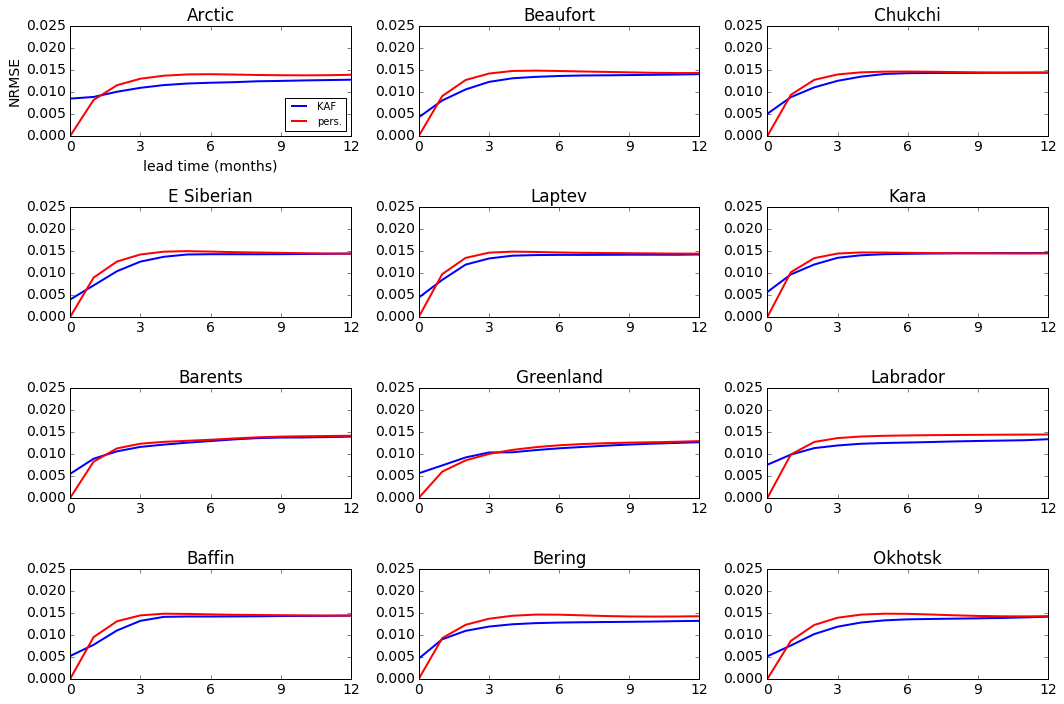

In [7]:
""" Figure 6 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_1_rms = np.squeeze(compData['pred_panel_1_rms'])
pred_panel_2_rms = np.squeeze(compData['pred_panel_2_rms'])
pred_panel_3_rms = np.squeeze(compData['pred_panel_3_rms'])
pred_panel_4_rms = np.squeeze(compData['pred_panel_4_rms'])
pred_panel_5_rms = np.squeeze(compData['pred_panel_5_rms'])
pred_panel_6_rms = np.squeeze(compData['pred_panel_6_rms'])
pred_panel_7_rms = np.squeeze(compData['pred_panel_7_rms'])
pred_panel_8_rms = np.squeeze(compData['pred_panel_8_rms'])
pred_panel_9_rms = np.squeeze(compData['pred_panel_9_rms'])
pred_panel_10_rms = np.squeeze(compData['pred_panel_10_rms'])
pred_panel_11_rms = np.squeeze(compData['pred_panel_11_rms'])
pred_panel_12_rms = np.squeeze(compData['pred_panel_12_rms'])
pred_panel_13_rms = np.squeeze(compData['pred_panel_13_rms'])
pred_panel_14_rms = np.squeeze(compData['pred_panel_14_rms'])
pred_panel_15_rms = np.squeeze(compData['pred_panel_15_rms'])
pred_panel_16_rms = np.squeeze(compData['pred_panel_16_rms'])

if dampedP == 1:
    pred_panel_1_rmsP = np.squeeze(compData['pred_panel_1_rmsDP'])
    pred_panel_2_rmsP = np.squeeze(compData['pred_panel_2_rmsDP'])
    pred_panel_3_rmsP = np.squeeze(compData['pred_panel_3_rmsDP'])
    pred_panel_4_rmsP = np.squeeze(compData['pred_panel_4_rmsDP'])
    pred_panel_5_rmsP = np.squeeze(compData['pred_panel_5_rmsDP'])
    pred_panel_6_rmsP = np.squeeze(compData['pred_panel_6_rmsDP'])
    pred_panel_7_rmsP = np.squeeze(compData['pred_panel_7_rmsDP'])
    pred_panel_8_rmsP = np.squeeze(compData['pred_panel_8_rmsDP'])
    pred_panel_9_rmsP = np.squeeze(compData['pred_panel_9_rmsDP'])
    pred_panel_10_rmsP = np.squeeze(compData['pred_panel_10_rmsDP'])
    pred_panel_11_rmsP = np.squeeze(compData['pred_panel_11_rmsDP'])
    pred_panel_12_rmsP = np.squeeze(compData['pred_panel_12_rmsDP'])
    pred_panel_13_rmsP = np.squeeze(compData['pred_panel_13_rmsDP'])
    pred_panel_14_rmsP = np.squeeze(compData['pred_panel_14_rmsDP'])
    pred_panel_15_rmsP = np.squeeze(compData['pred_panel_15_rmsDP'])
    pred_panel_16_rmsP = np.squeeze(compData['pred_panel_16_rmsDP'])
else:
    pred_panel_1_rmsP = np.squeeze(compData['pred_panel_1_rmsP'])
    pred_panel_2_rmsP = np.squeeze(compData['pred_panel_2_rmsP'])
    pred_panel_3_rmsP = np.squeeze(compData['pred_panel_3_rmsP'])
    pred_panel_4_rmsP = np.squeeze(compData['pred_panel_4_rmsP'])
    pred_panel_5_rmsP = np.squeeze(compData['pred_panel_5_rmsP'])
    pred_panel_6_rmsP = np.squeeze(compData['pred_panel_6_rmsP'])
    pred_panel_7_rmsP = np.squeeze(compData['pred_panel_7_rmsP'])
    pred_panel_8_rmsP = np.squeeze(compData['pred_panel_8_rmsP'])
    pred_panel_9_rmsP = np.squeeze(compData['pred_panel_9_rmsP'])
    pred_panel_10_rmsP = np.squeeze(compData['pred_panel_10_rmsP'])
    pred_panel_11_rmsP = np.squeeze(compData['pred_panel_11_rmsP'])
    pred_panel_12_rmsP = np.squeeze(compData['pred_panel_12_rmsP'])
    pred_panel_13_rmsP = np.squeeze(compData['pred_panel_13_rmsP'])
    pred_panel_14_rmsP = np.squeeze(compData['pred_panel_14_rmsP'])
    pred_panel_15_rmsP = np.squeeze(compData['pred_panel_15_rmsP'])
    pred_panel_16_rmsP = np.squeeze(compData['pred_panel_16_rmsP'])

tt = np.linspace(0, int(tLag) - 1, int(tLag))

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.plot(tt, pred_panel_1_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_1_rmsP, 'r', label='pers.')
plt.title('Arctic')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.xlabel('lead time (months)')
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])
# plt.ylabel(r'RMSE (km$^2$)')
plt.ylabel('NRMSE')
plt.legend(loc='lower right', prop={'size': 10})

plt.subplot(4, 3, 2)
plt.plot(tt, pred_panel_4_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_4_rmsP, 'r', label='pers.')
plt.title('Beaufort')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 3)
plt.plot(tt, pred_panel_3_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_3_rmsP, 'r', label='pers.')
plt.title('Chukchi')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 4)
plt.plot(tt, pred_panel_6_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_6_rmsP, 'r', label='pers.')
plt.title('E Siberian')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 5)
plt.plot(tt, pred_panel_7_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_7_rmsP, 'r', label='pers.')
plt.title('Laptev')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 6)
plt.plot(tt, pred_panel_10_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_10_rmsP, 'r', label='pers.')
plt.title('Kara')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 7)
plt.plot(tt, pred_panel_9_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_9_rmsP, 'r', label='pers.')
plt.title('Barents')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 8)
plt.plot(tt, pred_panel_11_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_11_rmsP, 'r', label='pers.')
plt.title('Greenland')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 9)
plt.plot(tt, pred_panel_13_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_13_rmsP, 'r', label='pers.')
plt.title('Labrador')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 10)
plt.plot(tt, pred_panel_12_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_12_rmsP, 'r', label='pers.')
plt.title('Baffin')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 11)
plt.plot(tt, pred_panel_15_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_15_rmsP, 'r', label='pers.')
plt.title('Bering')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

plt.subplot(4, 3, 12)
plt.plot(tt, pred_panel_16_rms, 'b', label='KAF')
plt.plot(tt, pred_panel_16_rmsP, 'r', label='pers.')
plt.title('Okhotsk')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig(SAVE_DIR + 'Fig6.eps', format='eps', dpi=1200)

/Users/dcomeau/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  a = empty(shape, dtype, order)


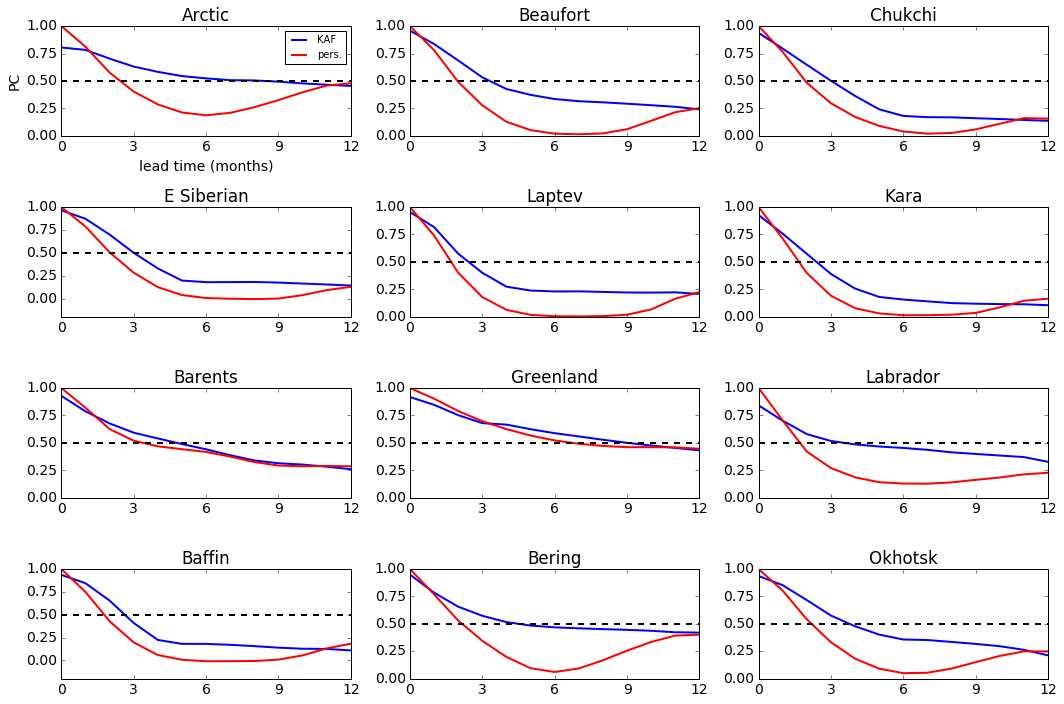

In [8]:
""" Figure 7 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_1_pc = np.squeeze(compData['pred_panel_1_pc'])
pred_panel_2_pc = np.squeeze(compData['pred_panel_2_pc'])
pred_panel_3_pc = np.squeeze(compData['pred_panel_3_pc'])
pred_panel_4_pc = np.squeeze(compData['pred_panel_4_pc'])
pred_panel_5_pc = np.squeeze(compData['pred_panel_5_pc'])
pred_panel_6_pc = np.squeeze(compData['pred_panel_6_pc'])
pred_panel_7_pc = np.squeeze(compData['pred_panel_7_pc'])
pred_panel_8_pc = np.squeeze(compData['pred_panel_8_pc'])
pred_panel_9_pc = np.squeeze(compData['pred_panel_9_pc'])
pred_panel_10_pc = np.squeeze(compData['pred_panel_10_pc'])
pred_panel_11_pc = np.squeeze(compData['pred_panel_11_pc'])
pred_panel_12_pc = np.squeeze(compData['pred_panel_12_pc'])
pred_panel_13_pc = np.squeeze(compData['pred_panel_13_pc'])
pred_panel_14_pc = np.squeeze(compData['pred_panel_14_pc'])
pred_panel_15_pc = np.squeeze(compData['pred_panel_15_pc'])
pred_panel_16_pc = np.squeeze(compData['pred_panel_16_pc'])

if dampedP == 1:
    pred_panel_1_pcP = np.squeeze(compData['pred_panel_1_pcDP'])
    pred_panel_2_pcP = np.squeeze(compData['pred_panel_2_pcDP'])
    pred_panel_3_pcP = np.squeeze(compData['pred_panel_3_pcDP'])
    pred_panel_4_pcP = np.squeeze(compData['pred_panel_4_pcDP'])
    pred_panel_5_pcP = np.squeeze(compData['pred_panel_5_pcDP'])
    pred_panel_6_pcP = np.squeeze(compData['pred_panel_6_pcDP'])
    pred_panel_7_pcP = np.squeeze(compData['pred_panel_7_pcDP'])
    pred_panel_8_pcP = np.squeeze(compData['pred_panel_8_pcDP'])
    pred_panel_9_pcP = np.squeeze(compData['pred_panel_9_pcDP'])
    pred_panel_10_pcP = np.squeeze(compData['pred_panel_10_pcDP'])
    pred_panel_11_pcP = np.squeeze(compData['pred_panel_11_pcDP'])
    pred_panel_12_pcP = np.squeeze(compData['pred_panel_12_pcDP'])
    pred_panel_13_pcP = np.squeeze(compData['pred_panel_13_pcDP'])
    pred_panel_14_pcP = np.squeeze(compData['pred_panel_14_pcDP'])
    pred_panel_15_pcP = np.squeeze(compData['pred_panel_15_pcDP'])
    pred_panel_16_pcP = np.squeeze(compData['pred_panel_16_pcDP'])    
else:
    pred_panel_1_pcP = np.squeeze(compData['pred_panel_1_pcP'])
    pred_panel_2_pcP = np.squeeze(compData['pred_panel_2_pcP'])
    pred_panel_3_pcP = np.squeeze(compData['pred_panel_3_pcP'])
    pred_panel_4_pcP = np.squeeze(compData['pred_panel_4_pcP'])
    pred_panel_5_pcP = np.squeeze(compData['pred_panel_5_pcP'])
    pred_panel_6_pcP = np.squeeze(compData['pred_panel_6_pcP'])
    pred_panel_7_pcP = np.squeeze(compData['pred_panel_7_pcP'])
    pred_panel_8_pcP = np.squeeze(compData['pred_panel_8_pcP'])
    pred_panel_9_pcP = np.squeeze(compData['pred_panel_9_pcP'])
    pred_panel_10_pcP = np.squeeze(compData['pred_panel_10_pcP'])
    pred_panel_11_pcP = np.squeeze(compData['pred_panel_11_pcP'])
    pred_panel_12_pcP = np.squeeze(compData['pred_panel_12_pcP'])
    pred_panel_13_pcP = np.squeeze(compData['pred_panel_13_pcP'])
    pred_panel_14_pcP = np.squeeze(compData['pred_panel_14_pcP'])
    pred_panel_15_pcP = np.squeeze(compData['pred_panel_15_pcP'])
    pred_panel_16_pcP = np.squeeze(compData['pred_panel_16_pcP'])

tt = np.linspace(0, int(tLag) - 1, int(tLag))

thresh = np.ones(tLag) * 0.5

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.plot(tt, pred_panel_1_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_1_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Arctic')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.xlabel('lead time (months)')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('PC')
plt.legend(loc='upper right', prop={'size': 10})

plt.subplot(4, 3, 2)
plt.plot(tt, pred_panel_4_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_4_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Beaufort')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 3)
plt.plot(tt, pred_panel_3_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_3_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Chukchi')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 4)
plt.plot(tt, pred_panel_6_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_6_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('E Siberian')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 5)
plt.plot(tt, pred_panel_7_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_7_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Laptev')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 6)
plt.plot(tt, pred_panel_10_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_10_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Kara')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 7)
plt.plot(tt, pred_panel_9_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_9_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Barents')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 8)
plt.plot(tt, pred_panel_11_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_11_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Greenland')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 9)
plt.plot(tt, pred_panel_13_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_13_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Labrador')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 10)
plt.plot(tt, pred_panel_12_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_12_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Baffin')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 11)
plt.plot(tt, pred_panel_15_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_15_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Bering')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

plt.subplot(4, 3, 12)
plt.plot(tt, pred_panel_16_pc, 'b', label='KAF')
plt.plot(tt, pred_panel_16_pcP, 'r', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.title('Okhotsk')
plt.xticks([0, 3, 6, 9, 12])
plt.xlim(0, 12)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig(SAVE_DIR + 'Fig7.eps', format='eps', dpi=1200)

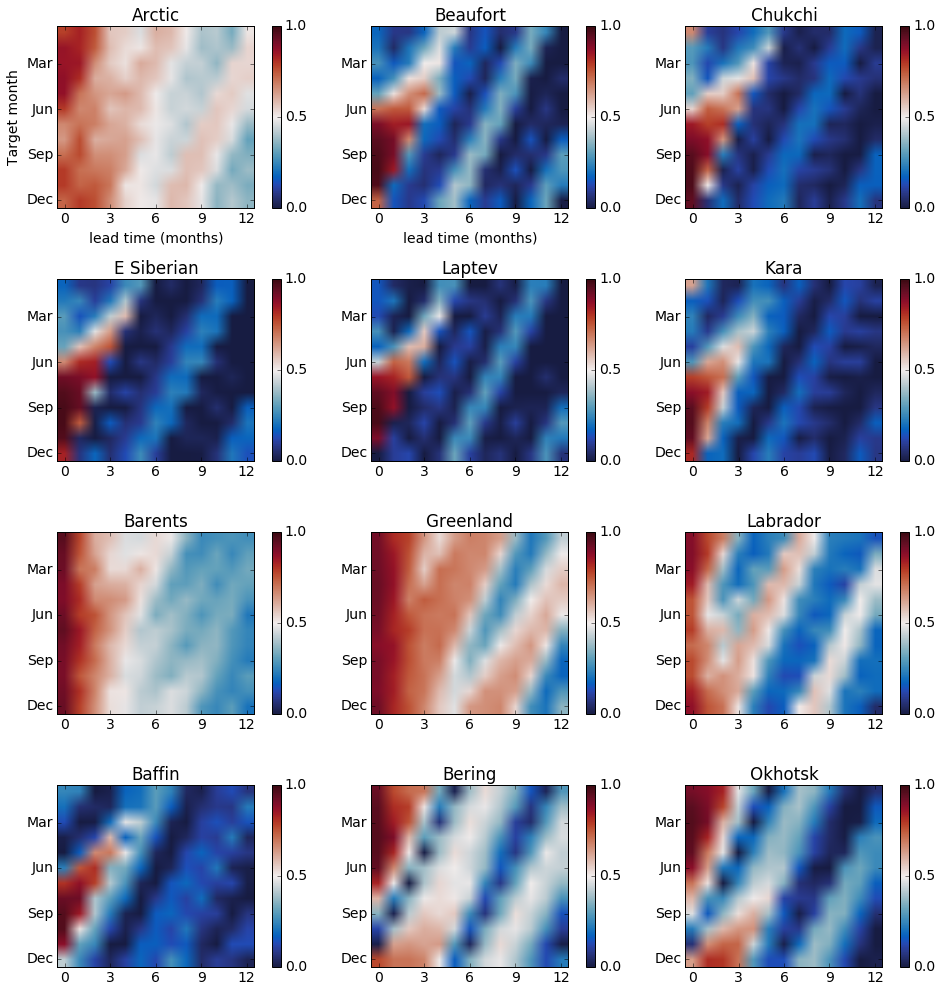

In [ ]:
""" Figure 8 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_shift_1_pcTM = compData['pred_panel_shift_1_pcTM']
# pred_panel_shift_1_pcTM = compData['pred_panel_shift_17_pcTM']
pred_panel_shift_2_pcTM = compData['pred_panel_shift_2_pcTM']
pred_panel_shift_3_pcTM = compData['pred_panel_shift_3_pcTM']
pred_panel_shift_4_pcTM = compData['pred_panel_shift_4_pcTM']
pred_panel_shift_5_pcTM = compData['pred_panel_shift_5_pcTM']
pred_panel_shift_6_pcTM = compData['pred_panel_shift_6_pcTM']
pred_panel_shift_7_pcTM = compData['pred_panel_shift_7_pcTM']
pred_panel_shift_8_pcTM = compData['pred_panel_shift_8_pcTM']
pred_panel_shift_9_pcTM = compData['pred_panel_shift_9_pcTM']
pred_panel_shift_10_pcTM = compData['pred_panel_shift_10_pcTM']
pred_panel_shift_11_pcTM = compData['pred_panel_shift_11_pcTM']
pred_panel_shift_12_pcTM = compData['pred_panel_shift_12_pcTM']
pred_panel_shift_13_pcTM = compData['pred_panel_shift_13_pcTM']
pred_panel_shift_14_pcTM = compData['pred_panel_shift_14_pcTM']
pred_panel_shift_15_pcTM = compData['pred_panel_shift_15_pcTM']
pred_panel_shift_16_pcTM = compData['pred_panel_shift_16_pcTM']

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(0, 1, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig8.eps', format='eps', dpi=500)

In [ ]:
""" Figure 9 """
embedWin = 12
iceVar = 'ica'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'
compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')
tLag = compData['tLag']

if dampedP == 1:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcTMDdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcTMDdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcTMDdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcTMDdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcTMDdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcTMDdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcTMDdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcTMDdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcTMDdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcTMDdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcTMDdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcTMDdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcTMDdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcTMDdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcTMDdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcTMDdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcTMDdiff'] 
else:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcTMdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcTMdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcTMdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcTMdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcTMdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcTMdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcTMdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcTMdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcTMdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcTMdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcTMdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcTMdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcTMdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcTMdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcTMdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcTMdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcTMdiff']

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(-0.5, 0.5, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig9.eps', format='eps', dpi=500)

In [ ]:
""" Figure 10 """
region = []
region.append('Arctic')
region.append('Beaufort')
region.append('Bering')
varUsed = []
varUsed.append('SIC')
varUsed.append('SIC_SST')
varUsed.append('SIC_SIT')
varUsed.append('SIC_SLP')
embedWin = 12
iceVar = 'ica'

pred_var_rms = np.zeros((3, 4, 13))
pred_var_pc = np.zeros((3, 4, 13))

pred_var_rmsP = np.zeros((3, 13))
pred_var_pcP = np.zeros((3, 13))

# load Arctic data
dataDir = WORK_DIR + region[0] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 0, :] = data['pred_rms']
pred_var_pc[0, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[0] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 1, :] = data['pred_rms']
pred_var_pc[0, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[0] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 2, :] = data['pred_rms']
pred_var_pc[0, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[0] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[0, 3, :] = data['pred_rms']
pred_var_pc[0, 3, :] = data['pred_pc']

# load Beaufort data
dataDir = WORK_DIR + region[1] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 0, :] = data['pred_rms']
pred_var_pc[1, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[1] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 1, :] = data['pred_rms']
pred_var_pc[1, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[1] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 2, :] = data['pred_rms']
pred_var_pc[1, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[1] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[1, 3, :] = data['pred_rms']
pred_var_pc[1, 3, :] = data['pred_pc']

# load Bering data
dataDir = WORK_DIR + region[2] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 0, :] = data['pred_rms']
pred_var_pc[2, 0, :] = data['pred_pc']
dataDir = WORK_DIR + region[2] + '_' + varUsed[1] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 1, :] = data['pred_rms']
pred_var_pc[2, 1, :] = data['pred_pc']
dataDir = WORK_DIR + region[2] + '_' + varUsed[2] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 2, :] = data['pred_rms']
pred_var_pc[2, 2, :] = data['pred_pc']
dataDir = WORK_DIR + region[2] + '_' + varUsed[3] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_var_rms[2, 3, :] = data['pred_rms']
pred_var_pc[2, 3, :] = data['pred_pc']

# load persistence data
dataDir = WORK_DIR + region[0] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[0, :] = data['pred_rmsDP']
    pred_var_pcP[0, :] = data['pred_pcDP']    
else:
    pred_var_rmsP[0, :] = data['pred_rmsP']
    pred_var_pcP[0, :] = data['pred_pcP']

dataDir = WORK_DIR + region[1] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[1, :] = data['pred_rmsDP']
    pred_var_pcP[1, :] = data['pred_pcDP']    
else:
    pred_var_rmsP[1, :] = data['pred_rmsP']
    pred_var_pcP[1, :] = data['pred_pcP']
dataDir = WORK_DIR + region[2] + '_' + varUsed[0] + '_q' + str(embedWin) + \
    '_train_100_499/'
data = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
if dampedP == 1:
    pred_var_rmsP[2, :] = data['pred_rmsDP']
    pred_var_pcP[2, :] = data['pred_pcDP']    
else:
    pred_var_rmsP[2, :] = data['pred_rmsP']
    pred_var_pcP[2, :] = data['pred_pcP']

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'lines.linewidth': 2})

tLag = data['tLag']
tt = np.linspace(0, int(tLag) - 1, int(tLag))

thresh = np.ones(tLag) * 0.5

fig = plt.figure()
plt.subplot(3, 2, 1)
plt.plot(tt, pred_var_rms[0, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[0, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[0, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[0, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[0, :], '--', label='pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.xlabel('lead time (months)')
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])
plt.ylabel(r'km$^2$')
plt.legend(loc='lower right', prop={'size': 8})
plt.title('Arctic NRMSE')

plt.subplot(3, 2, 2)
plt.plot(tt, pred_var_pc[0, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[0, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[0, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[0, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[0, :], '--', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title('Arctic PC')

plt.subplot(3, 2, 3)
plt.plot(tt, pred_var_rms[1, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[1, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[1, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[1, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[1, :], '--', label='pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])
plt.title('Beaufort NRMSE')

plt.subplot(3, 2, 4)
plt.plot(tt, pred_var_pc[1, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[1, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[1, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[1, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[1, :], '--', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title('Beaufort PC')

plt.subplot(3, 2, 5)
plt.plot(tt, pred_var_rms[2, 0, :], label='SIC')
plt.plot(tt, pred_var_rms[2, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_rms[2, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_rms[2, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_rmsP[2, :], '--', label='pers.')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])
plt.title('Bering NRMSE')

plt.subplot(3, 2, 6)
plt.plot(tt, pred_var_pc[2, 0, :], label='SIC')
plt.plot(tt, pred_var_pc[2, 1, :], label='SIC, SST')
plt.plot(tt, pred_var_pc[2, 2, :], label='SIC, SIT')
plt.plot(tt, pred_var_pc[2, 3, :], label='SIC, SLP')
plt.plot(tt, pred_var_pcP[2, :], '--', label='pers.')
plt.plot(tt, thresh, 'k--')
plt.xticks([0, 3, 6, 9, 12])
plt.yticks([0, 0.5, 1])
plt.title('Bering PC')

fig.set_figheight(10)
fig.set_figwidth(8)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig10.eps', format='eps', dpi=1200)

In [ ]:
""" Figure 11 """
region = 'Arctic'
embedWin = 12
varsUsed = 'SIC_SST_SIT'

### full training data ###
dataDir = WORK_DIR + region + '_SIC_SST_SIT_q' + str(embedWin) + \
    '_train_100_499/'
# concentration anomaly data
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTM = dataPredICA['pred_pcTM']


### short training data ###
dataDir = WORK_DIR + region + '_SIC_SST_SITq48_q' + str(embedWin) + \
    '_train_100_499/'
# concentration anomaly data
dataPredICAS = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTMS = dataPredICAS['pred_pcTM']

cTicks = np.linspace(0, 1, 3)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': False})
# plt.rcParams.update({'font.family': 'serif'})

fig = plt.figure()
plt.subplot(121)
plt.imshow(pred_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('SIT q=12')
plt.subplot(122)
plt.imshow(pred_pcTMS, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('SIT q=48')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.3, 0.03, 0.4])
# cax = plt.axes([0.85, 0.1, 0.075, 0.5])
cax = plt.axes([0.85, 0.21, 0.04, 0.57])

plt.colorbar(cax=cax, ticks=cTicks)
fig.set_figwidth(8)
plt.savefig(SAVE_DIR + 'Fig11.eps', format='eps', dpi=1200)

In [ ]:
""" Figure 12 """
embedWin = 12
iceVar = 'iva'
varsUsed = 'SIC_SST_SLP'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'

compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')

tLag = compData['tLag']

pred_panel_shift_1_pcTM = compData['pred_panel_shift_1_pcTM']
# pred_panel_shift_1_pcTM = compData['pred_panel_shift_17_pcTM']
pred_panel_shift_2_pcTM = compData['pred_panel_shift_2_pcTM']
pred_panel_shift_3_pcTM = compData['pred_panel_shift_3_pcTM']
pred_panel_shift_4_pcTM = compData['pred_panel_shift_4_pcTM']
pred_panel_shift_5_pcTM = compData['pred_panel_shift_5_pcTM']
pred_panel_shift_6_pcTM = compData['pred_panel_shift_6_pcTM']
pred_panel_shift_7_pcTM = compData['pred_panel_shift_7_pcTM']
pred_panel_shift_8_pcTM = compData['pred_panel_shift_8_pcTM']
pred_panel_shift_9_pcTM = compData['pred_panel_shift_9_pcTM']
pred_panel_shift_10_pcTM = compData['pred_panel_shift_10_pcTM']
pred_panel_shift_11_pcTM = compData['pred_panel_shift_11_pcTM']
pred_panel_shift_12_pcTM = compData['pred_panel_shift_12_pcTM']
pred_panel_shift_13_pcTM = compData['pred_panel_shift_13_pcTM']
pred_panel_shift_14_pcTM = compData['pred_panel_shift_14_pcTM']
pred_panel_shift_15_pcTM = compData['pred_panel_shift_15_pcTM']
pred_panel_shift_16_pcTM = compData['pred_panel_shift_16_pcTM']

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(0, 1, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig12.eps', format='eps', dpi=500)

In [ ]:
""" Figure 13 """
embedWin = 12
iceVar = 'iva'
varsUsed = 'SIC_SST_SITq48'

dataDir = WORK_DIR + iceVar + '/' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'
compData = sio.loadmat(dataDir + 'comp_data' + str(flag) + '.mat')
tLag = compData['tLag']

if dampedP == 1:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcTMDdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcTMDdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcTMDdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcTMDdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcTMDdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcTMDdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcTMDdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcTMDdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcTMDdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcTMDdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcTMDdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcTMDdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcTMDdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcTMDdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcTMDdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcTMDdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcTMDdiff']
else:
    pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_1_pcTMdiff']
#     pred_panel_shift_1_pcTMdiff = compData['pred_panel_shift_17_pcTMdiff']
    pred_panel_shift_2_pcTMdiff = compData['pred_panel_shift_2_pcTMdiff']
    pred_panel_shift_3_pcTMdiff = compData['pred_panel_shift_3_pcTMdiff']
    pred_panel_shift_4_pcTMdiff = compData['pred_panel_shift_4_pcTMdiff']
    pred_panel_shift_5_pcTMdiff = compData['pred_panel_shift_5_pcTMdiff']
    pred_panel_shift_6_pcTMdiff = compData['pred_panel_shift_6_pcTMdiff']
    pred_panel_shift_7_pcTMdiff = compData['pred_panel_shift_7_pcTMdiff']
    pred_panel_shift_8_pcTMdiff = compData['pred_panel_shift_8_pcTMdiff']
    pred_panel_shift_9_pcTMdiff = compData['pred_panel_shift_9_pcTMdiff']
    pred_panel_shift_10_pcTMdiff = compData['pred_panel_shift_10_pcTMdiff']
    pred_panel_shift_11_pcTMdiff = compData['pred_panel_shift_11_pcTMdiff']
    pred_panel_shift_12_pcTMdiff = compData['pred_panel_shift_12_pcTMdiff']
    pred_panel_shift_13_pcTMdiff = compData['pred_panel_shift_13_pcTMdiff']
    pred_panel_shift_14_pcTMdiff = compData['pred_panel_shift_14_pcTMdiff']
    pred_panel_shift_15_pcTMdiff = compData['pred_panel_shift_15_pcTMdiff']
    pred_panel_shift_16_pcTMdiff = compData['pred_panel_shift_16_pcTMdiff']

plt.rcParams.update({'font.size': 14})
# plt.rcParams.update({'font.family': 'serif'})

cTicks = np.linspace(-0.5, 0.5, 3)
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']

fig = plt.figure()
plt.subplot(4, 3, 1)
plt.imshow(pred_panel_shift_1_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (months)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.title('Arctic')
# plt.title('Central Arctic')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 2)
plt.imshow(pred_panel_shift_4_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Beaufort')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 3)
plt.imshow(pred_panel_shift_3_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Chukchi')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 4)
plt.imshow(pred_panel_shift_6_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('E Siberian')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 5)
plt.imshow(pred_panel_shift_7_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Laptev')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 6)
plt.imshow(pred_panel_shift_10_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Kara')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 7)
plt.imshow(pred_panel_shift_9_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Barents')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 8)
plt.imshow(pred_panel_shift_11_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Greenland')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 9)
plt.imshow(pred_panel_shift_13_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Labrador')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 10)
plt.imshow(pred_panel_shift_12_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Baffin')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 11)
plt.imshow(pred_panel_shift_15_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Bering')
plt.colorbar().set_ticks(cTicks)

plt.subplot(4, 3, 12)
plt.imshow(pred_panel_shift_16_pcTMdiff,
           cmap=cmocean.cm.balance, clim=(-0.5, 0.5))
plt.xticks((0, 3, 6, 9, 12))
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Okhotsk')
plt.colorbar().set_ticks(cTicks)

fig.set_figheight(14)
fig.set_figwidth(14)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'Fig13.eps', format='eps', dpi=500)

In [ ]:
""" Figure 14 """
region = 'Arctic'
embedWin = 12
varsUsed = 'SIC_SST_SIT'

# full training data
dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_499/'
dataPredICA = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTM = dataPredICA['pred_pcTM']


# short training data
dataDir = WORK_DIR + region + '_' + varsUsed + '_q' + str(embedWin) + \
    '_train_100_139/'
dataPredICAS = sio.loadmat(dataDir + 'pred_ica' + str(flag) + '.mat')
pred_pcTMS = dataPredICAS['pred_pcTM']

cTicks = np.linspace(0, 1, 3)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': False})

fig = plt.figure()
plt.subplot(121)
plt.imshow(pred_pcTM, cmap=cmocean.cm.balance, clim=(0, 1))
yLabels = ['Mar', 'Jun', 'Sep', 'Dec']
yLabelsN = ['M', 'J', 'S', 'D']
plt.yticks((2, 5, 8, 11), yLabels)
plt.ylabel('Target month')
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.title('Full Training')
plt.subplot(122)
plt.imshow(pred_pcTMS, cmap=cmocean.cm.balance, clim=(0, 1))
plt.xticks((0, 3, 6, 9, 12))
plt.xlabel('lead time (month)')
plt.yticks((2, 5, 8, 11), yLabels)
plt.title('Short Training')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.21, 0.04, 0.57])

plt.colorbar(cax=cax, ticks=cTicks)
fig.set_figwidth(8)
plt.savefig(SAVE_DIR + 'Fig14.eps', format='eps', dpi=1200)